In [1]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
start_date = "2020-1-1"
end_date = "2025-9-1"
ticker = "^GSPC"

df = yf.download(ticker, start_date, end_date)
df.columns = df.columns.get_level_values(0)
df.columns.name = None

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
def compute_rsi(df, column, period):
    delta = df[column].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(com=period-1, adjust=False).mean()
    avg_loss = loss.ewm(com=period-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    df[f"RSI_{period}"] = 100 - (100 / (1+rs))
    
    return df

df = compute_rsi(df, "Close", 14)

In [4]:
df["Log_returns"] = np.log(df["Close"]/df["Close"].shift(1))
df["Historical_vol"] = df["Log_returns"].rolling(window=20).std()*np.sqrt(252)

df["Lag_1"] = df["Log_returns"].shift(1)
df["Lag_2"] = df["Log_returns"].shift(2)
df["Lag_5"] = df["Log_returns"].shift(5) 

df["Log_volume"] = np.log(df["Volume"])

C:\Users\sonny\anaconda3\envs\project_finance\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df = df.drop(["High", "Close", "Open", "Low", "Volume"], axis=1)
df

,RSI_14,Log_returns,Historical_vol,Lag_1,Lag_2,Lag_5,Log_volume
Date,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,21.964514
2020-01-03,0.000000,-0.007085,NaN,NaN,NaN,NaN,21.971648
2020-01-06,3.681968,0.003527,NaN,-0.007085,NaN,NaN,22.032263
2020-01-07,3.569288,-0.002807,NaN,0.003527,-0.007085,NaN,21.957548
2020-01-08,8.810506,0.004890,NaN,-0.002807,0.003527,NaN,22.038827
...,...,...,...,...,...,...,...
2025-08-25,58.943260,-0.004276,0.120061,0.015072,-0.004012,-0.000101,22.124220
2025-08-26,61.395130,0.004125,0.120075,-0.004276,0.015072,-0.005875,22.305883
2025-08-27,62.785123,0.002388,0.119969,0.004125,-0.004276,-0.002435,22.144850


RSI_14             1
Log_returns        1
Historical_vol    20
Lag_1              2
Lag_2              3
Lag_5              6
Log_volume         1
dtype: int64


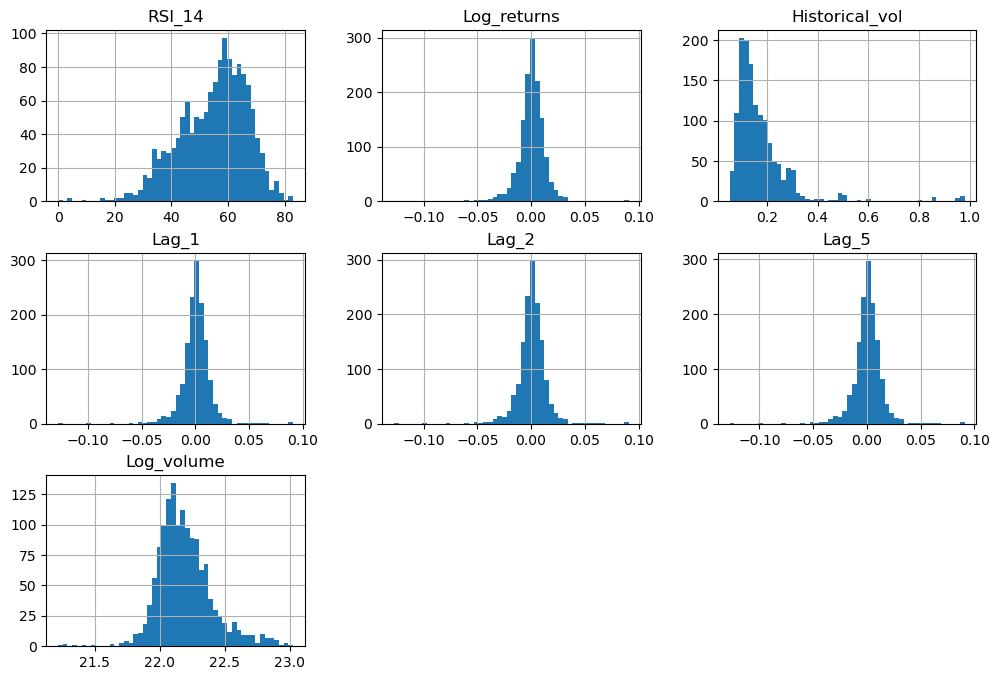

In [6]:
df = df.replace([np.inf, -np.inf], np.nan)
print(df.isna().sum())
df.hist(bins=50, figsize=(12,8))
plt.show()

In [7]:
df = df.dropna(subset=["Log_returns"])

split = int(len(df)*0.8)
train_set = df.iloc[:split]
test_set = df.iloc[split:]

print(f"Train set {train_set.index.min()} -> {train_set.index.max()}")
print(f"Test set {test_set.index.min()} -> {test_set.index.max()}")

Train set 2020-01-03 00:00:00 -> 2024-07-11 00:00:00
Test set 2024-07-12 00:00:00 -> 2025-08-29 00:00:00


### Exploration 

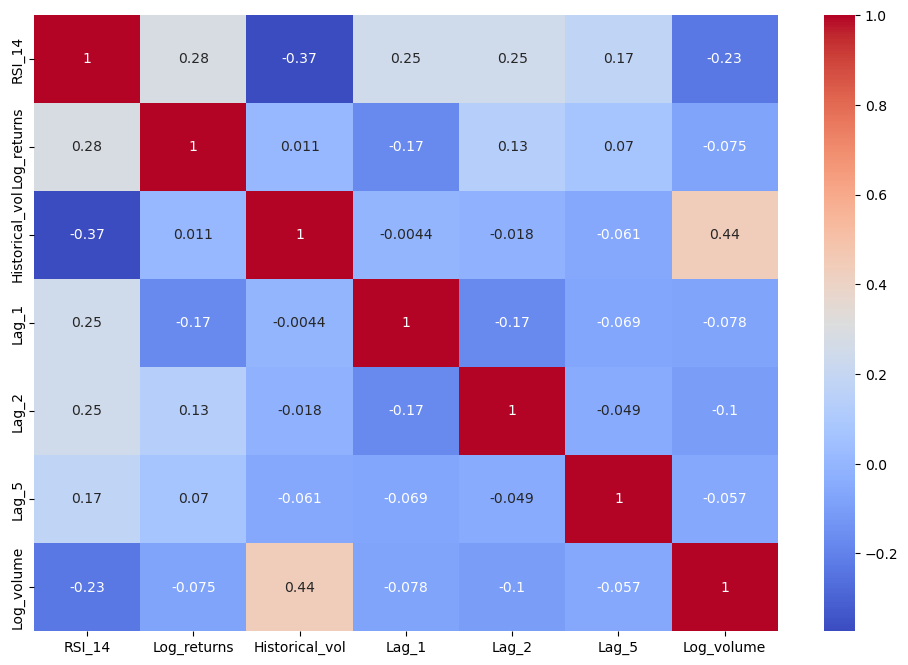

In [8]:
import seaborn as sns 
corr_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

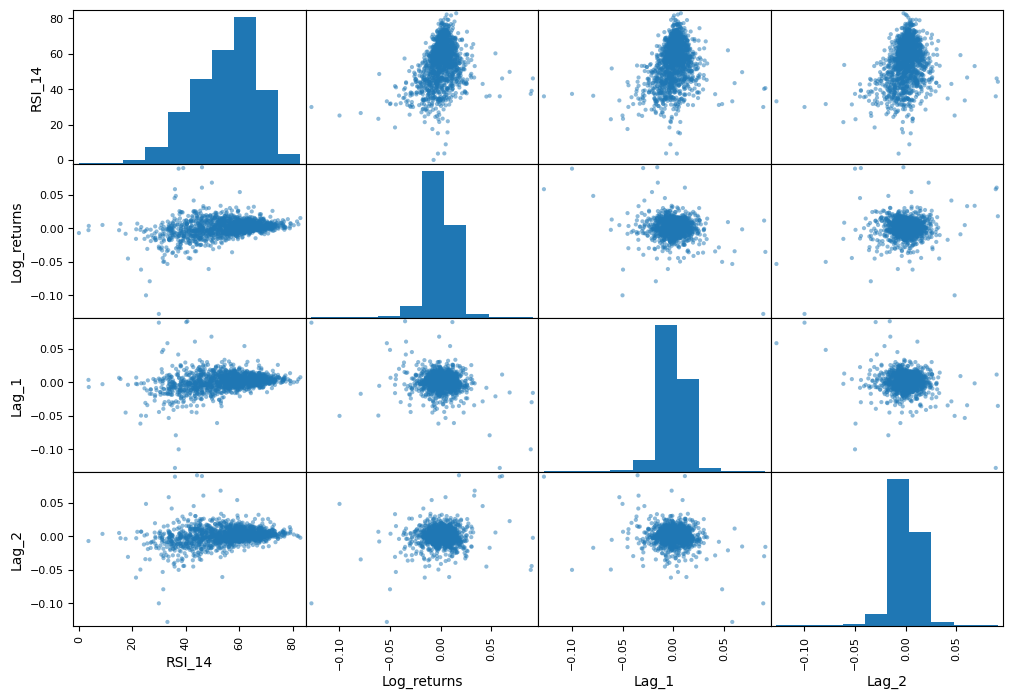

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["RSI_14", "Log_returns", "Lag_1", "Lag_2"]
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

### Pipeline

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

# Colonnes
log_attribute = ["Historical_vol"]
yj_attribute = ["RSI_14"]

X_train, X_test = train_set.drop("Log_returns", axis=1), test_set.drop("Log_returns", axis=1)
y_train, y_test = train_set["Log_returns"], test_set["Log_returns"]

other_attributes = X_train.drop(log_attribute + yj_attribute, axis=1).columns

# Log pipeline
log_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, inverse_func=np.expm1, 
                                validate=True, feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Yeo-Johnson pipeline
yj_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("yj", PowerTransformer(method="yeo-johnson")),
    ("scale", StandardScaler())
])

# Others variables
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ("log", log_pipeline, log_attribute),
    ("yj", yj_pipeline, yj_attribute),
    ("num", num_pipeline, other_attributes)
])

# X/y split
X_train, X_test = train_set.drop("Log_returns", axis=1), test_set.drop("Log_returns", axis=1)
y_train, y_test = train_set["Log_returns"], test_set["Log_returns"]

# Apply preprocessor 
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [11]:
preprocessor

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>,
                                                                      validate=True)),
                                                 ('scale', StandardScaler())]),
                                 ['Historical_vol']),
                                ('yj',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('yj', PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['RSI_14']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 Index(['Lag_1', 'Lag_2', 'Lag_5', 'Log_volume'], dtype='object'))])

### Model Function

In [15]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import mean_squared_error, r2_score

def decision_tree(X_train, y_train, X_test, y_test, preprocessor=None, optimize=False, n_splits=5):
    base_model = DecisionTreeRegressor(max_depth=5, random_state=42)

    pipe = make_pipeline(preprocessor, base_model) if preprocessor else base_model
    
    tscv=TimeSeriesSplit(n_splits=n_splits)

    # Optimize model
    if optimize:
        param_grid = {
            "decisiontreeregressor__max_depth": [3, 5, 7, 9, None],
            "decisiontreeregressor__min_samples_leaf": [1, 5, 10, 20],
            "decisiontreeregressor__min_samples_split": [2, 5, 10, 20]
        }

        grid_search = GridSearchCV(
            pipe, 
            param_grid, 
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_tree = grid_search.best_estimator_
        best_params = grid_search.best_params_
        cv_rmse = -grid_search.best_score_
        cv_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

    # Baseline model
    else:
        score = cross_val_score(pipe, X_train, y_train, cv=tscv,
                                scoring="neg_root_mean_squared_error", n_jobs=-1)

        best_params = None       
        cv_rmse = -score.mean()
        cv_std = score.std()
        
        best_tree = pipe
        best_tree.fit(X_train, y_train)

    
    y_pred_train = best_tree.predict(X_train)
    y_pred_test = best_tree.predict(X_test)

    metrics = {
        "Model": best_tree,
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train R²": r2_score(y_train, y_pred_train),
        "Test R²": r2_score(y_test, y_pred_test),
        "Best Params": best_params,
        "CV RMSE": cv_rmse,
        "CV STD": cv_std
    }

    print(f"RMSE train : {metrics['Train RMSE']:.4f}")
    print(f"R² train   : {metrics['Train R²']:.4f}")
    print(f"RMSE test  : {metrics['Test RMSE']:.4f}")
    print(f"R² test    : {metrics['Train R²']:.4f}")
    print(f"Best CV RMSE : {cv_rmse:.4f} (±{cv_std:.4f})")
    if best_params:
        print(f"Best params : {best_params}")
    
    return metrics

### Plot Function 

In [19]:
from sklearn import tree
def plot(X_train, X_test, y_test, version, model_name, max_depth=3):
    model = version["Model"].named_steps["decisiontreeregressor"]
    y_pred_test = model.predict(X_test)
    importances = model.feature_importances_
    residuals = y_test - y_pred_test

    # Tree plot
    plt.figure(figsize=(16,8))
    tree.plot_tree(
        model,
        filled=True,
        max_depth=max_depth,
        feature_names=X_train.columns
    )
    plt.title(f"{model_name}")
    plt.show()


    # Features importance
    feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    feat_imp.plot(kind="bar", figsize=(10,5))
    plt.title(f"Features Importance - ({model_name})")
    plt.xticks(rotation=45)
    plt.show()


    # Actual Vs. Predicted values
    plt.figure(figsize=(10,5))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Real returns")
    plt.ylabel("Predicted returns")
    plt.title(f"Actual Vs. Predicted values - ({model_name})")
    plt.show()


    # Residuals distribution
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.title("Residuals distribution")
    plt.xlabel("Prediction error (y - ŷ)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

### Decision Tree Baseline 

In [20]:
base_tree = decision_tree(X_train, y_train, X_test, y_test, preprocessor=preprocessor, n_splits=5)

RMSE train : 0.0102
R² train   : 0.4643
RMSE test  : 0.0111
R² test    : 0.4643
Best CV RMSE : 0.0099 (±0.0031)


C:\Users\sonny\anaconda3\envs\project_finance\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


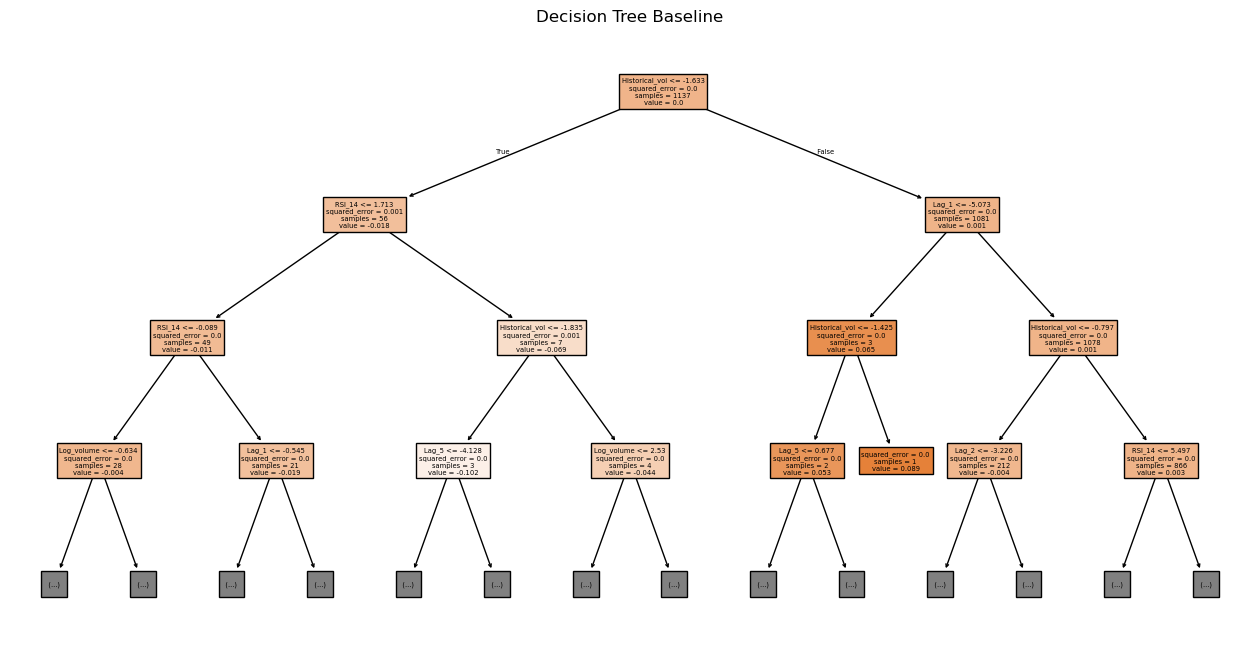

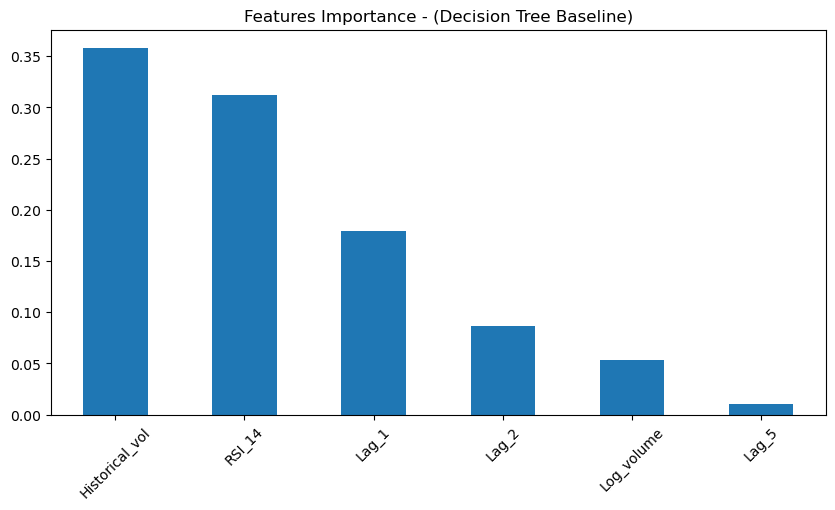

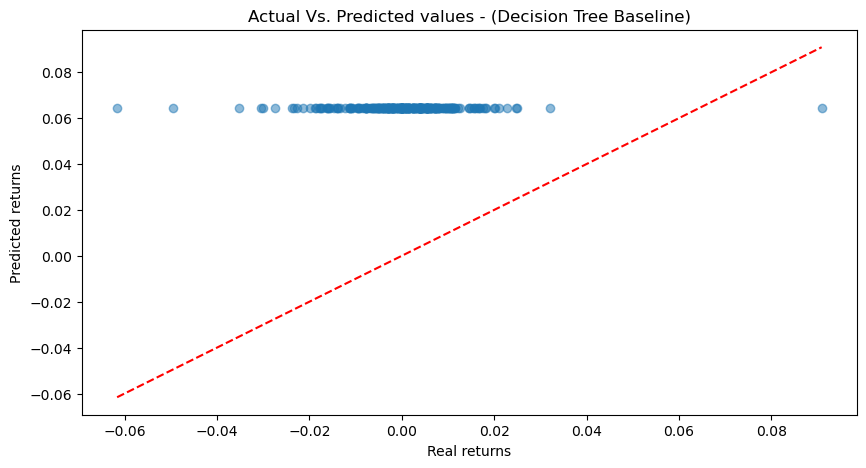

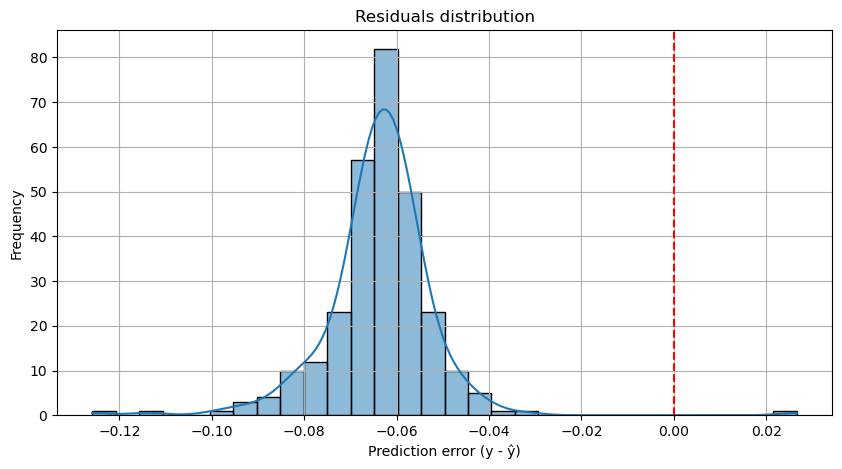

In [21]:
plot(X_train, X_test, y_test, base_tree, model_name="Decision Tree Baseline")

### Optimize Decision Tree

In [22]:
opt_tree = decision_tree(X_train, y_train, X_test, y_test, preprocessor=preprocessor, optimize=True, n_splits=5)

RMSE train : 0.0117
R² train   : 0.2928
RMSE test  : 0.0109
R² test    : 0.2928
Best CV RMSE : 0.0098 (±0.0028)
Best params : {'decisiontreeregressor__max_depth': 3, 'decisiontreeregressor__min_samples_leaf': 1, 'decisiontreeregressor__min_samples_split': 20}


C:\Users\sonny\anaconda3\envs\project_finance\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


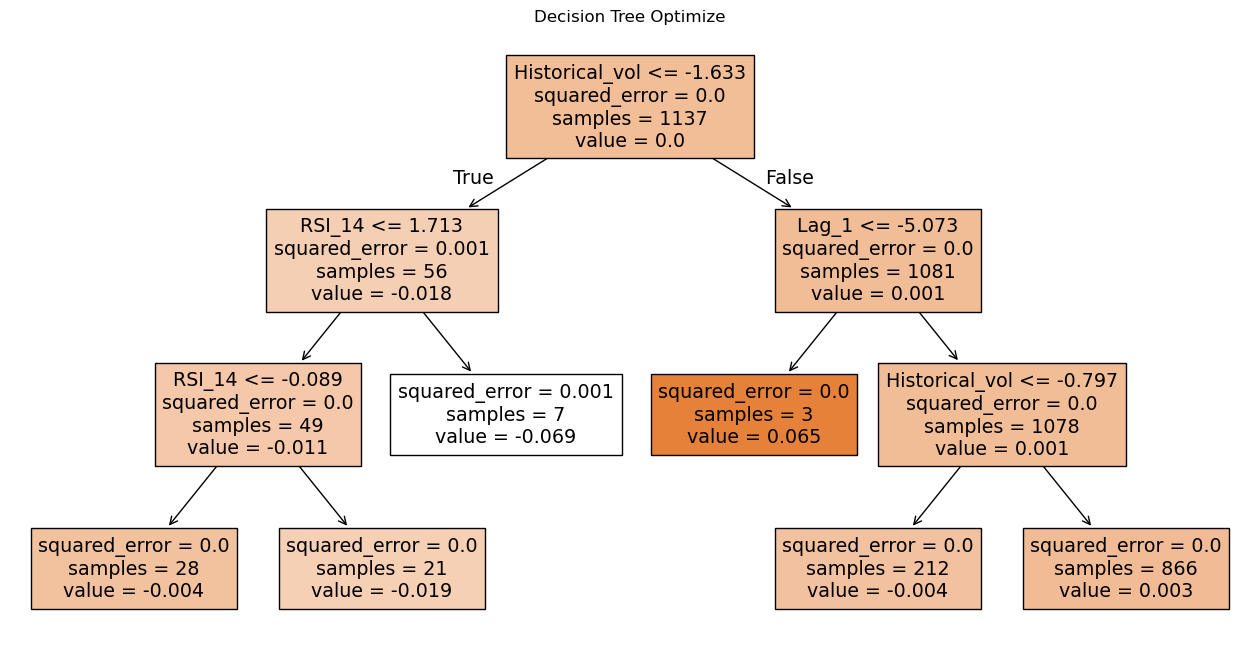

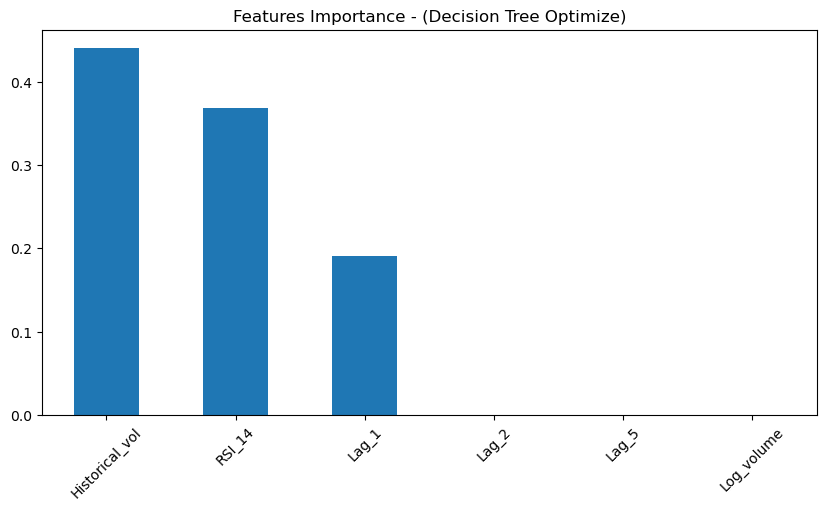

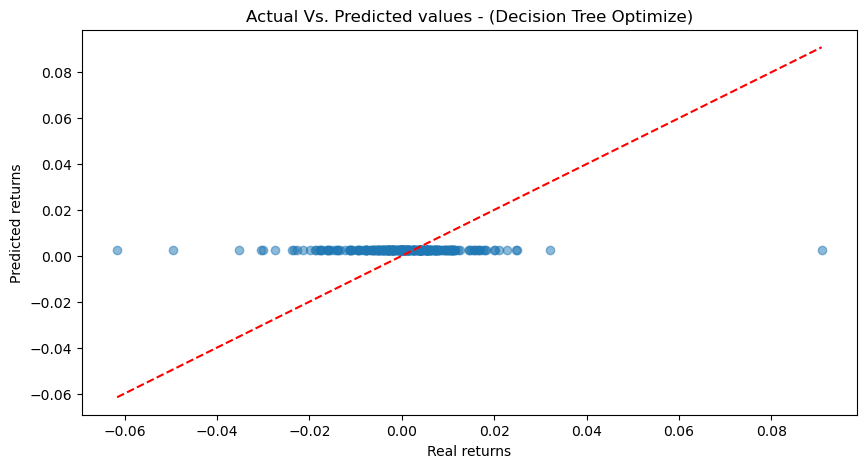

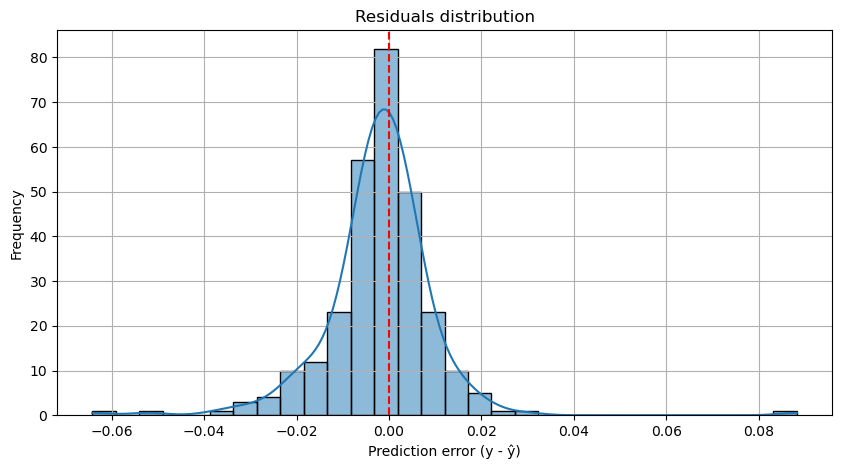

In [23]:
plot(X_train, X_test, y_test, opt_tree, model_name="Decision Tree Optimize")

### Comaprison 

In [27]:
models = {
    "Baseline" : base_tree,
    "Optimize" : opt_tree
}
df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in models.items()
])
df.drop(columns=["Model", "Best Params"], axis=1)

,Train RMSE,Test RMSE,Train R²,Test R²,CV RMSE,CV STD
0,0.010153,0.011135,0.464278,0.117279,0.009921,0.003144
1,0.011665,0.010866,0.292808,0.159491,0.009769,0.002819
